In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import warnings
warnings.filterwarnings("ignore")
# sns to plot data
import seaborn as sns
import matplotlib.pyplot as plt
# Wordcloud to visualize words
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
# Import stopwords
stopwords = stopword_list = nltk.corpus.stopwords.words('english')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression

# 1. Phân tích dữ liệu

Mục đích của bước này: đọc và phân tích các đặc trưng của 2 bộ dữ liệu: câu hỏi sincere (tạm dịch là câu hỏi chân thành) và câu hỏi insincere (tạm dịch là câu hỏi không chân thành), cũng như làm các bước cẩn thiết để xử lý dữ liệu trước khi đưa vào mô hình huấn luyện, sao cho mô hình đạt hiệu năng tốt nhất.

*(Ngoài ra, đa số các đoạn code đều có comment bên trên để nói qua mục đích và kết quả dự kiến của dòng code đó.)*

#### Đoạn code dưới có mục đích đơn giản là nhập 2 bộ dữ liệu được Quora cho sẵn: train (dữ liệu dùng để huấn luyện) và test (dữ liệu dùng để đánh giá hiệu năng của mô hình)

In [ ]:
# Data import
train_data = pd.read_csv("../input/quora-insincere-questions-classification/train.csv")
test_data = pd.read_csv("../input/quora-insincere-questions-classification/test.csv")

# Print imported datapoints
print(f"{len(train_data):,} datapoints")
print(f"{len(test_data):,} test datapoints")

# Print all available columns in csv
print(train_data.head())

##### Như kết quả phía trên: ta thu được hơn 1.3 triệu câu hỏi dùng để train, và gần 400 nghìn câu hỏi dùng để đánh giá hiệu năng của mô hình. Ngay bên dưới sẽ là format dữ liệu của bộ ```train_data```, bao gồm:

* Cột ```qid```: Đây chính là id của câu hỏi, mỗi câu hỏi đều có 1 id khác nhau và không có id nào giống nhau cả.
* Cột ```question_text```: Đây chính là cột chứa các câu hỏi. Chúng ta sẽ phân tích và sàng lọc cột này trước khi đưa vào mô hình để huấn luyện, đảm bảo dữ liệu sẽ "sạch" nhất có thể.
* Cột ```target```: Đây chính là cột chứa kết quả đánh giá câu hỏi có phải chân thành hay không chân thành, câu hỏi ```question_text``` có ```target = 0``` sẽ được đánh giá là câu hỏi chân thành, và câu hỏi có ```target = 1``` sẽ được đánh giá là không chân thành.

#### Đoạn code tiếp theo sẽ dùng để biểu diễn dữ liệu ```train_data``` thành một đồ thị, trong đó chiều ngang của đồ thị sẽ biểu diễn loại câu hỏi, còn chiều dọc sẽ biểu thị tổng số câu hỏi có trong loại câu hỏi đó.

In [ ]:
sns.countplot(train_data['target'])

#### Nhật xét sơ bộ về phân bố dữ liệu: Dữ liệu bên trên bao gồm có khoảng 1.2 triệu câu hỏi chân thành, và khoảng 100 nghìn câu hỏi không chân thành. Số lượng câu hỏi chân thành chiếm tới hơn 93% tổng số bộ dữ liệu, vậy nên dữ liệu dùng để huấn luyện rất không cân bằng, cần phải đề ra giải pháp để cân bằng lại dữ liệu.

## Quá trình phân tích và sàng lọc dữ liệu

#### Đoạn code bên dưới sẽ kiểm tra xem có tập dữ liệu nào trong tập ```train_data``` và ```test_data``` là ```null``` hay không


In [ ]:
print('train_data null datapoints: ', train_data.isnull().sum())
test_data.isnull().sum()

#### Đoạn code bên dưới sẽ vẽ ra biểu đồ box plot để xác định phân bố độ dài của các câu hỏi trong từng loại câu hỏi khác nhau. Cách đọc đồ thị box plot sẽ được hiển thị bên dưới:
![Cách đọc đồ thị box plot](https://www.simplypsychology.org/boxplot.jpg)
#### Giải thích sơ bộ:
* ```min```, ```max```: Đây chính là 2 giá trị nhỏ nhất và lớn nhất của tập dữ liệu trong box plot.
* Lower quartile ```Q1```: 25% giá trị trong tập dữ liệu thấp hơn đường ```Q1``` sẽ nằm dưới đường kẻ đó.
* Median: 50% giá trị trong tập dữ liệu thấp hơn đường median sẽ nằm dưới đường kẻ đó, 50% còn lại sẽ nằm bên trên.
* Upper quartile ```Q2```: 75% giá trị trong tập dữ liệu thấp hơn đường ```Q2``` sẽ nằm dưới đường kẻ đó, 25% còn lại sẽ nằm bên trên.
* Khung interquartile ```IQR```: khoảng dữ liệu nằm giữa 25% và 75% của dữ liệu sẽ nằm trong khoảng này. Các thông số bên trong ```IQR``` đã được mô tả bên trên.

In [ ]:
# Get question length and then plot
question_length = []
for x in (train_data['question_text']):
    question_length.append(len(x))
# np.append(train_data, question_length, axis=1)
train_data['question_length'] = question_length
sns.boxplot(x="target", y='question_length', data=train_data)
train_data.drop('question_length', axis=1)

#### Nhận xét phân bố độ dài các câu hỏi trong tập dữ liệu huấn luyện:
* Độ dài các câu hỏi từ các tập câu hỏi chân thành luôn nhỏ hơn độ dài câu hỏi trong tập không chân thành: trừ điểm ```min``` ra thì Q1, Q2, median của câu hỏi chân thành luôn có giá trị thấp hơn không chân thành. Từ đây ta có 2 phỏng đoán:
    * Đa số các câu hỏi không chân thành đều dài hơn các câu hỏi chân thành (có thể là các câu hỏi spam, các câu hỏi mang tính chất quảng cáo, chửi bới, ...)
    * Bộ dữ liệu câu hỏi không chân thành bị chuẩn đoán sai bởi các câu hỏi có quá nhiều độ nhiễu (ví dụ như có quá nhiều ký tự đặc biệt, ký tự HTML, ký tự toán học, ...). Vậy nên có thể có câu hỏi toàn chứa các ký tự HTML (như ```<div></div>```, ```<body></body>```, ...) đều bị đánh dấu là không chân thành, mặc dù nó không hề như vậy.
* Câu hỏi có độ dài lớn nhất trong tập câu hỏi chân thành rơi vào khoảng 800 ký tự. Ta sẽ xem rõ câu hỏi này là gì.
* Câu hỏi có độ dài lớn nhất trong tập câu hỏi không chân thành có thể lên tới 1000 ký tự, và cũng là câu hỏi có độ dài lớn nhất trong tập dữ liệu huấn luyện. Ta cũng sẽ phải xem xét câu hỏi này.

#### Ngoài ra, ta sẽ bỏ cột ```qid``` trong tập dữ liệu vì không cần thiết, và để giải phóng bộ nhớ vì quá trình huấn luyện sẽ cần rất nhiều bộ nhớ.

#### Đoạn code dưới sẽ tìm độ dài lớn nhất và độ dài lớn nhì của 2 loại câu hỏi trong tập dữ liệu huấn luyện

*(Trường ```question_length``` đã được thêm vào ở trên đoạn code vẽ box plot.)*

In [ ]:
# Find max for both sincere and insincere question length
max_sincere = 0
second_max_sincere = 0
max_insincere = 0
second_max_insincere = 0

for x in train_data.itertuples():
#     print(x[4])
    if (x[3] == 0 and x[4] > max_sincere):
        max_sincere = x[4]
    if (x[3] == 1 and x[4] > max_insincere):
        max_insincere = x[4]

for x in train_data.itertuples():
    if (x[3] == 0 and x[4] < max_sincere and x[4] > second_max_sincere):
        second_max_sincere = x[4]
    if (x[3] == 1 and x[4] < max_insincere and x[4] > second_max_insincere):
        second_max_insincere = x[4]
        
print('Max sincere question length: ', max_sincere)
print('Max insincere question length: ', max_insincere)

print('Second max sincere question length: ', second_max_sincere)
print('Second max insincere question length: ', second_max_insincere)


In [ ]:
# Find the question with that length
for x in train_data.itertuples():
    if (x[4] == max_sincere and x[3] == 0):
        print('Sincere question: ', x[2], '\n')
    if (x[4] == max_insincere and x[3] == 1):
        print('Insincere question: ', x[2], '\n')
        
print('\n\n\n')
        
for x in train_data.itertuples():
    if (x[4] == second_max_sincere and x[3] == 0):
        print('Second max sincere question: ', x[2], '\n')
    if (x[4] == second_max_insincere and x[3] == 1):
        print('Second max insincere question: ', x[2], '\n')

#### Nhận xét kết quả thu được bên trên:
* Ở các câu hỏi có độ dài lớn nhất của 2 loại câu hỏi, ta có thể thấy rõ rằng câu hỏi không chân thành chính là một câu hỏi toán học, và có rất nhiều ký tự đặc biệt trong đó, nhưng điều lạ là câu hỏi này bị đánh dấu là không chân thành, mặc dù nó chỉ là một câu hỏi toán học thông thường? Nhìn qua ta biết được đây chính là các ký hiệu được dùng bởi LaTeX để viết ra những công thức toán học. Dùng công cụ LaTeX Viewer có sẵn trên mạng, ta thu được công thức toán học sau: 
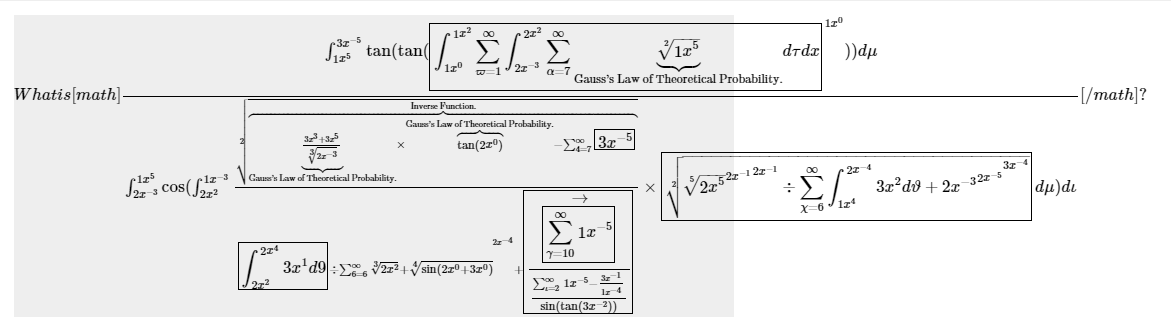
    * Ta thấy rõ là câu hỏi trên không có gì đáng nghi ngờ về mặt ngữ nghĩa, tuy nhiên, vì khi chuyển thể từ dạng MathML về văn bản thông thường, các ký hiệu đánh dấu vẫn được giữ nguyên, làm nhiễu dữ liệu, vậy nên bị đánh dấu không chính xác.
* Câu hỏi chân thành có độ dài lớn nhất đã được đánh dấu đúng, không có gì đáng nghi ở đây.
* Ở các câu hỏi có độ dài lớn nhì của 2 loại câu hỏi, ta thấy rằng cả 2 câu hỏi đều có rất nhiều ký hiệu toán học làm nhiễu dữ liệu. Hình ảnh LaTeX của 2 câu hỏi trên được hiển thị như dưới:
    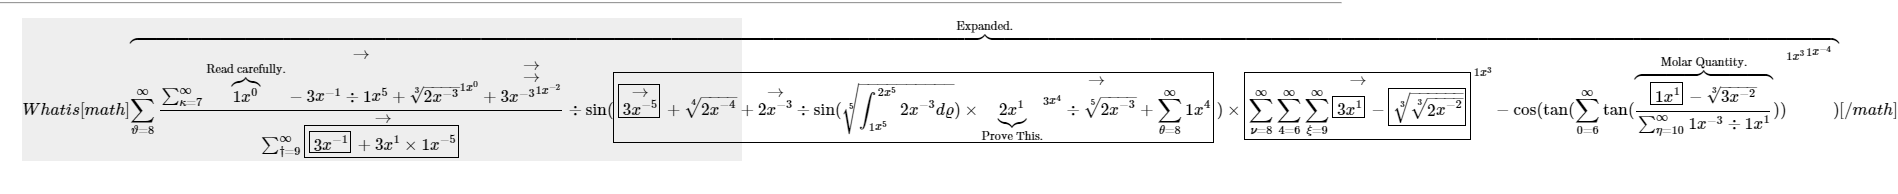

    *Câu hỏi không chân thành có độ dài lớn nhì*
    
    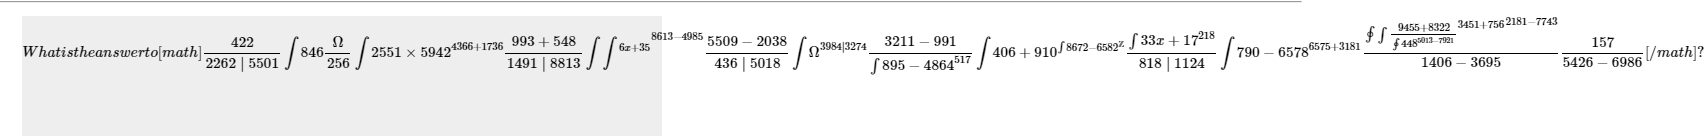
    *Câu hỏi chân thành có độ dài lớn nhì*
* Một lần nữa, mặt ngữ nghĩa của 2 câu hỏi không có gì đáng ngờ, nhưng số ký tự trong câu hỏi không chân thành (878) lớn hơn nhiều so với câu hỏi chân thành (509), vậy nên có khả năng là nó bị đánh dấu không chân thành vì có quá nhiều ký tự đặc biệt

#### Ta phải loại bỏ các ký tự không thuộc trong bảng chữ cái, và có thể sẽ loại bỏ chữ số, nhưng vì lý do sẽ nêu bên dưới khiến em sẽ không loại bỏ số mà chỉ loại bỏ các ký tự không thuộc bảng chữ cái thôi.

#### Đoạn code bên dưới sẽ sử dụng thư viện WordCloud để hình dung hoá tần suất xuất hiện của các từ có trong câu hỏi.


In [ ]:
# WordCloud function
def cloud(text, title, size = (10,7)):
    # Process text
    wordcloud = WordCloud(width=800, height=400, collocations=False).generate(" ".join(text))
    
    # Visualization
    fig = plt.figure(figsize=size, dpi=80, )
    plt.imshow(wordcloud,interpolation='bilinear')
    # Show title but not working?
    plt.title(title, fontsize=25,color='w')
    plt.tight_layout(pad=1)
    plt.show()

In [ ]:
# Separate sincere and insincere datapoints for visualization

def separate_data(data, target):
    new_data = []
    # Itertuples to iterate each row in train_data
    for x in data.itertuples():
        # index 3 represents 'target', 2 represents question_text
        if (x[3] == target): new_data.append(x[2])
    return new_data

sincere_train_data = separate_data(train_data, 0)
insincere_train_data = separate_data(train_data, 1)

#### Tần suất các từ có trong tập câu hỏi không chân thành

In [ ]:
cloud(insincere_train_data, 'Insincere questions')

#### Tần suất các từ có trong tập câu hỏi không chân thành

In [ ]:
cloud(sincere_train_data, 'Sincere questions')

#### Nhận xét về tần suất các từ trong tập huấn luyện: 
* Trong các từ xuất hiện nhiều nhất (biểu diễn bởi chữ to: chữ càng to thì tần suất xuất hiện càng nhiều), có một chút sự tương đồng giữa các từ (ví dụ như people, will, ...).
* Tuy nhiên, tần suất các từ stop word (như những động từ to-be: is, are, am, ...) có tần suất xuất hiện rất nhiều, có thể ảnh hưởng tới quá trình học, nên ta phải loại bỏ các từ đó sử dụng một tập từ điển stop word có sẵn


# 2. Resampling
#### Bởi dữ liệu trong tập ```train_data``` không cân bằng, nên ta cần phải tăng lượng câu hỏi không chân thành lên sao cho tỉ lệ câu hỏi chân thành và câu hỏi không chân thành đạt tỉ lệ chấp nhận được.

#### Đoạn code bên dưới sẽ phục vụ mục đích trên, sử dụng hàm ```resample``` có trong ```sklearn```

In [ ]:
from sklearn.utils import resample

sincere_questions = train_data[train_data.target == 0]
insincere_questions = train_data[train_data.target == 1]

# # 1:3 Ratio
# new_train_data = pd.concat([resample(sincere_questions, replace = True, n_samples = len(insincere_questions)*3), insincere_questions])

new_train_data = pd.concat([resample(sincere_questions, replace = True, n_samples = len(insincere_questions)*5), insincere_questions])

In [ ]:
sns.countplot(new_train_data['target'])

In [ ]:
# Set new_train_data to train_data
train_data = new_train_data

#### Đoạn code bên dưới chỉ phục vụ mục đích là chuyển cột ```target``` sang một mảng mới.

In [ ]:
# Separate data labels
target_array = train_data.pop('target')
target_array.value_counts(True)

#Drop train_data qid as it is unneccesary
train_data.drop('qid', axis=1, inplace=True)


# 3. Tiền xử lý dữ liệu

#### Đoạn code bên dưới sẽ có mục đích như sau:
* Loại bỏ các ký tự không có trong bảng chữ cái (trừ dấu cách), bằng cách dùng regular expression: hiệu năng nhanh hơn là tìm và thay thế
* Trước khi loại bỏ các ký tự, tìm các từ viết tắt (như it's, aren't, doesn't, ...) và khôi phục về nguyên bản (it is, are not, does not, ...)
* KHÔNG loại bỏ số (có các số như 69, 420 là những số có ngữ nghĩa liên quan tới mức độ chân thành và không chân thành)
#### Tất cả việc tìm và thay thế sẽ sử dụng ```regex``` vì có hiệu năng nhanh hơn.


In [ ]:
#Preprocess

#Remove all non-characters
non_char_regex= re.compile(r'[^A-Za-z0-9]+')
# Separate sentence into array of words
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# Group similar words and treat them as one word.
l = WordNetLemmatizer()

# Common miss-spell dictionary, taken from various online sites
miss_spell_dictionary = {
  'colour': 'color',
  'centre': 'center',
  'favourite': 'favorite',
  'travelling': 'traveling',
  'counselling': 'counseling',
  'theatre': 'theater',
  'cancelled': 'canceled',
  'labour': 'labor',
  'organisation': 'organization',
  'wwii': 'world war 2',
  'citicise': 'criticize',
  'youtu ': 'youtube ',
  'Qoura': 'Quora',
  'sallary': 'salary',
  'Whta': 'What',
  'narcisist': 'narcissist',
  'howdo': 'how do',
  'whatare': 'what are',
  'howcan': 'how can',
  'howmuch': 'how much',
  'howmany': 'how many',
  'whydo': 'why do',
  'doI': 'do I',
  'theBest': 'the best',
  'howdoes': 'how does',
  'mastrubation': 'masturbation',
  'mastrubate': 'masturbate',
  "mastrubating": 'masturbating',
  'pennis': 'penis',
  'Etherium': 'bitcoin',
  'narcissit': 'narcissist',
  'bigdata': 'big data',
  '2k17': '2017',
  '2k18': '2018',
  'qouta': 'quota',
  'exboyfriend': 'ex boyfriend',
  'airhostess': 'air hostess',
  "whst": 'what',
  'watsapp': 'whatsapp',
  'demonitisation': 'demonetization',
  'demonitization': 'demonetization',
  'demonetisation': 'demonetization',
  'electroneum': 'bitcoin',
  'nanodegree': 'degree',
  'hotstar': 'star',
  'dream11': 'dream',
  'ftre': 'fire',
  'tensorflow': 'framework',
  'unocoin': 'bitcoin',
  'lnmiit': 'limit',
  'unacademy': 'academy',
  'altcoin': 'bitcoin',
  'altcoins': 'bitcoin',
  'litecoin': 'bitcoin',
  'coinbase': 'bitcoin',
  'cryptocurency': 'cryptocurrency',
  'simpliv': 'simple',
  'quoras': 'quora',
  'schizoids': 'psychopath',
  'remainers': 'remainder',
  'twinflame': 'soulmate',
  'quorans': 'quora',
  'brexit': 'demonetized',
  'iiest': 'institute',
  'dceu': 'comics',
  'pessat': 'exam',
  'uceed': 'college',
  'bhakts': 'devotee',
  'boruto': 'anime',
  'cryptocoin': 'bitcoin',
  'blockchains': 'blockchain',
  'fiancee': 'fiance',
  'redmi': 'smartphone',
  'oneplus': 'smartphone',
  'qoura': 'quora',
  'deepmind': 'framework',
  'ryzen': 'cpu',
  'whattsapp': 'whatsapp',
  'undertale': 'adventure',
  'zenfone': 'smartphone',
  'cryptocurencies': 'cryptocurrencies',
  'koinex': 'bitcoin',
  'zebpay': 'bitcoin',
  'binance': 'bitcoin',
  'whtsapp': 'whatsapp',
  'reactjs': 'framework',
  'bittrex': 'bitcoin',
  'bitconnect': 'bitcoin',
  'bitfinex': 'bitcoin',
  'yourquote': 'your quote',
  'whyis': 'why is',
  'jiophone': 'smartphone',
  'dogecoin': 'bitcoin',
  'onecoin': 'bitcoin',
  'poloniex': 'bitcoin',
  '7700k': 'cpu',
  'angular2': 'framework',
  'segwit2x': 'bitcoin',
  'hashflare': 'bitcoin',
  '940mx': 'gpu',
  'openai': 'framework',
  'hashflare': 'bitcoin',
  '1050ti': 'gpu',
  'nearbuy': 'near buy',
  'freebitco': 'bitcoin',
  'antminer': 'bitcoin',
  'filecoin': 'bitcoin',
  'whatapp': 'whatsapp',
  'empowr': 'empower',
  '1080ti': 'gpu',
  'crytocurrency': 'cryptocurrency',
  '8700k': 'cpu',
  'whatsaap': 'whatsapp',
  'g4560': 'cpu',
  'payymoney': 'pay money',
  'fuckboys': 'fuck boys',
  'intenship': 'internship',
  'zcash': 'bitcoin',
  'demonatisation': 'demonetization',
  'narcicist': 'narcissist',
  'mastuburation': 'masturbation',
  'trignometric': 'trigonometric',
  'cryptocurreny': 'cryptocurrency',
  'howdid': 'how did',
  'crytocurrencies': 'cryptocurrencies',
  'phycopath': 'psychopath',
  'bytecoin': 'bitcoin',
  'possesiveness': 'possessiveness',
  'scollege': 'college',
  'humanties': 'humanities',
  'altacoin': 'bitcoin',
  'demonitised': 'demonetized',
  'brasília': 'brazilia',
  'accolite': 'accolyte',
  'econimics': 'economics',
  'varrier': 'warrier',
  'quroa': 'quora',
  'statergy': 'strategy',
  'langague': 'language',
  'splatoon': 'game',
  '7600k': 'cpu',
  'gate2018': 'gate 2018',
  'in2018': 'in 2018',
  'narcassist': 'narcissist',
  'jiocoin': 'bitcoin',
  'hnlu': 'hulu',
  '7300hq': 'cpu',
  'weatern': 'western',
  'interledger': 'blockchain',
  'deplation': 'deflation',
  'cryptocurrencies': 'cryptocurrency',
  'bitcoin': 'blockchain cryptocurrency',
  
}

# Shortened, experimental contraction dict
contraction_dict = {
    "let's": "let us",
    "won't": "will not",
    "shan't": "shall not",
    "'m": " am",
    "'s": " is",
    "'re": " are",
    "'ve": " have",
    "n't": " not",
    "'d": " would",
    "'ll": " will",
    "in'": "ing"    
}

#Restore miss-spelled words
miss_spell_regex = re.compile('(%s)' % '|'.join(miss_spell_dictionary.keys()))
def restore_miss_spell(text):
    def replace(match):
        return miss_spell_dictionary[match.group(0)]
    return miss_spell_regex.sub(replace, text)

# Restore contraction
contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
def restore_contraction(text):
    def replace(match):
        return contraction_dict[match.group(0)]
    return contraction_re.sub(replace, text)

def remove_stopwords (text):
    word_tokens = word_tokenize(text) 
    filtered_sentence = [w for w in word_tokens if not w in stopwords] 
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stopwords: 
            filtered_sentence.append(w)
    filtered_sentence = ' '.join(filtered_sentence)
    return filtered_sentence

# Main process
def process(text): 
    text = text.lower()
    text = restore_contraction(text)
    text = restore_miss_spell(text)
    text = non_char_regex.sub(' ', text)
    text = remove_stopwords(text)
    text = ' '.join([l.lemmatize(word) for word in word_tokenize(text)])
    return text 

all_texts = np.array([process(x[0]) for x in train_data.values])
print("Questions process done")

In [ ]:
example_sentence = """This is a sample sentence, showing off the stop words filtration."""

print(remove_stopwords(example_sentence)) 
  

In [ ]:
print(all_texts[:10])

# 4. Quá trình huấn luyện model
#### Đầu tiên là chia tập ```train_data``` và ```test_data```. Bộ dữ liệu ```train_data``` sẽ được chia ra như sau: 80% tập dữ liệu sẽ được dùng để huấn luyện, và 20% còn lại sẽ được dùng để test.

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(all_texts, target_array.values, test_size=0.2, random_state=0)

#### Đoạn code bên dưới sẽ sử dụng tập ```train_data``` và ```test_data``` đã tách để tạo ra các vector đếm.

Ta sẽ sử dụng ```Vectorizer``` để tách các từ khác nhau trong 1 câu hỏi và đếm tần suất xuất hiện của các từ đó. Làm vậy thì ngữ pháp của các câu hỏi sẽ được bỏ qua và không quan trọng trong việc xác định câu hỏi chân thành hay không chân thành.

Các từ khác nhau xuất hiện trong câu hỏi, cũng như tần suất của chúng sẽ được gộp vào một Bag-of-Words (gọi tắt là bow). Sẽ có 2 loại BoW: ```bow_train (Full Bag-of-Words)``` sẽ dùng để chứa những câu có số từ được trích xuất trong các câu là 1, còn ```bow_train2 (Reduced Bag-of-Words)``` sẽ chứa những câu hỏi có số từ được trích xuất trong các câu là 2. Để minh hoạ rõ hơn ta sẽ lấy 1 ví dụ

```This document is the first document.```
    
```And this is the second document```
    
* Với ```bow_train```, bộ từ vựng tổng hợp từ 2 câu trên là: ```[and, document, first, is, this, the, second]```, với tần suất các từ đó xuất hiện trong câu đầu tiên là: ```[0, 2, 1, 1, 1, 1, 0]``` và trong câu thứ 2: ```[1, 1, 0, 1, 1, 1, 1]```
* Với ```bow_train2```, bộ từ vựng tổng hợp từ 2 câu trên là: ```['and this', 'document is', 'first document', 'is the', 'second document', 'this document', 'the first', 'the second', 'this is']```, với tần suất xuất hiện trong câu 1 là: ```[0, 1, 1, 1, 0, 1, 1, 0, 0]```, và câu 2: ```[1, 0, 0, 1, 1, 0, 0, 1, 1]```

Trong khi tạo bộ ```bow_train2```, có 3 tham số được đề ra trong hàm ```CountVectorizer```:
* ```min_df```: Khi tạo bộ từ vựng, những từ xuất hiện có tần suất thấp hơn ```min_df``` sẽ được loại bỏ. Thiết lập tham số này sẽ giúp loại bỏ những từ ngữ có tần suất quá ít (như những câu hỏi có xen lẫn vài từ có ngôn ngữ khác tiếng Anh), tránh ảnh hưởng tới quá trình học máy.
* ```max_df```: Khi tạo bộ từ vựng, những từ xuất hiện có tần suất cao hơn ```max_df``` sẽ được loại bỏ. Thiếp lập tham số này sẽ giúp loại bỏ những từ ngữ được dùng quá thường xuyên (như những từ stop words), nhưng vì chúng ta đã loại bỏ các từ stop word rồi, nên tham số sẽ được đặt là ```0.999```
* ```ngram_range```: Số từ được ```Vectorizer``` lọc ra và đẩy vào từ điển.

Ngoài ra, ```Vectorizer``` còn có kèm theo bộ lọc các từ stop words thông dụng của tiếng Anh, ta có thể sử dụng nó thay cho bộ lọc stop words bên trên đã làm, nhưng về kết quả thì sẽ có thể khác nhau.

*(Bộ ```bow_train2``` sẽ dùng chủ yếu là để đánh giá và thử nghiệm)*

In [ ]:
vectorizer = CountVectorizer()
vectorizer2 = CountVectorizer(min_df = 0.0001, max_df = 0.999, ngram_range = (2,2)) 
bow_train = vectorizer.fit_transform(train_x) 
bow_train2 = vectorizer2.fit_transform(train_x) 
print(bow_train.shape)
print(bow_train2.shape)
bow_test = vectorizer.transform(test_x)
bow_test2 = vectorizer2.transform(test_x)

#### 2 đoạn code bên dưới chỉ phục vụ mục đích là dùng 2 BoW đã xây dựng bên trên và bắt đầu huấn luyện, cũng như kiểm tra hiệu năng của mô hình.
#### Ngoài ra, thuật toán Decision Tree cũng được thêm vào để phục vụ mục đích so sánh hiệu năng của thuật toán Logistic Regression
#### Một vài đặc điểm của mô hình Logistic Regression:
* Trong bài toán này, mức độ ```penalty``` được đặt ở mức L2 (Ridge Regression), bởi mức L1 (Lasso Regression) không được hỗ trợ bởi thư viện ```lbfgs```

In [ ]:
# Logistic Regression (full BoW)

print("Full BoW Result")
logistic = LogisticRegression(C=3.5) 
logistic.fit(bow_train, train_y) 
train_predictions = logistic.predict(bow_train)
train_acc = accuracy_score(train_y, train_predictions)
train_f1 = f1_score(train_y, train_predictions) 
print(f"Train accuracy: {train_acc:.2%}, F1: {train_f1:.4f}") 
test_predictions = logistic.predict(bow_test)
test_acc = accuracy_score(test_y, test_predictions) 
test_f1 = f1_score(test_y, test_predictions) 
print(f"Test accuracy:  {test_acc:.2%}, F1: {test_f1:.4f}")

In [ ]:
# Logistic Regression (reduced BoW)

print(f"Reduced BoW Result")
logistic2 = LogisticRegression(C=3.5) 
logistic2.fit(bow_train2, train_y) 
train_predictions = logistic2.predict(bow_train2)
train_acc = accuracy_score(train_y, train_predictions)
train_f1 = f1_score(train_y, train_predictions) 
print(f"Train accuracy: {train_acc:.4%}, F1: {train_f1:.4f}") 
test_predictions = logistic2.predict(bow_test2)
test_acc = accuracy_score(test_y, test_predictions) 
test_f1 = f1_score(test_y, test_predictions) 
print(f"Test accuracy:  {test_acc:.4%}, F1: {test_f1:.4f}")


In [ ]:
# Decision Tree (full BoW)
from sklearn.tree import DecisionTreeClassifier

print(f"Results of decision tree on full bag-of-words")
dt = DecisionTreeClassifier(max_depth=30) 
dt.fit(bow_train, train_y)
train_predictions = dt.predict(bow_train)
train_acc = accuracy_score(train_y, train_predictions) 
train_f1 = f1_score(train_y, train_predictions) 
print(f"Training accuracy: {train_acc:.2%}, F1: {train_f1:.4f}") 
test_predictions = dt.predict(bow_test)
test_acc = accuracy_score(test_y, test_predictions) 
test_f1 = f1_score(test_y, test_predictions) 
print(f"Testing accuracy:  {test_acc:.2%}, F1: {test_f1:.4f}")

# 5. Tổng hợp kết quả thu được

## Kết quả full BoW chưa lọc stop word, chưa có resampling

Train accuracy: 95.66%, F1: 0.5759

Test accuracy:  95.36%, F1: 0.5428


## Kết quả reduced BoW chưa lọc stop word, chưa có resampling

Train accuracy: 95.25%, F1: 0.5190

Test accuracy:  95.16%, F1: 0.5082

## Kết quả full BoW đã lọc stop word, chưa có resampling
Train accuracy: 95.68%, F1: 0.5753

Test accuracy:  95.09%, F1: 0.5107

## Kết quả reduced BoW đã lọc stop word, chưa có resampling, có cài đặt giới hạn df (min = 0.0001, max = 0.999)
Train accuracy: 95.1808%, F1: 0.5061

Test accuracy:  95.0675%, F1: 0.4945

## Kết quả reduced BoW đã lọc stop word, chưa có resampling, chưa cài đặt giới hạn df
Train accuracy: 99.0091%, F1: 0.9140

Test accuracy:  94.6525%, F1: 0.3530

## Kết quả full BoW đã lọc stop word, đã có resampling với tỉ lệ 2:1
Train accuracy: 91.92%, F1: 0.8757

Test accuracy:  87.85%, F1: 0.8099

## Kết quả reduced BoW đã lọc stop word, đã có resampling với tỉ lệ 2:1
Train accuracy: 77.9344%, F1: 0.5636

Test accuracy:  77.1047%, F1: 0.5435

## Kết quả full BoW đã lọc stop word, đã có resampling với tỉ lệ 3:1
Train accuracy: 92.18%, F1: 0.8368

Test accuracy:  89.29%, F1: 0.7720

## Kết quả reduced BoW đã lọc stop word, đã có resampling với tỉ lệ 3:1
Train accuracy: 81.7226%, F1: 0.4973

Test accuracy:  81.3003%, F1: 0.4753

## Kết quả full BoW đã lọc stop word, đã có resampling với tỉ lệ 4:1
Train accuracy: 92.74%, F1: 0.8065

Test accuracy:  90.35%, F1: 0.7409

## Kết quả reduced BoW đã lọc stop word, đã có resampling với tỉ lệ 4:1
Train accuracy: 84.3101%, F1: 0.4372

Test accuracy:  84.0069%, F1: 0.4279


## Kết quả full BoW của Decision Tree, đã có resampling với tỉ lệ 4:1
Training accuracy: 88.28%, F1: 0.6437

Testing accuracy:  86.95%, F1: 0.6097

## Kết quả full BoW đã lọc stop word, đã có resampling với tỉ lệ 5:1
Train accuracy: 92.98%, F1: 0.7710

Test accuracy:  91.06%, F1: 0.7053

## Kết quả reduced BoW đã lọc stop word, đã có resampling với tỉ lệ 5:1
Train accuracy: 86.3180%, F1: 0.3913

Test accuracy:  85.9021%, F1: 0.3726

## Kết quả full BoW của Decision Tree, đã có resampling với tỉ lệ 5:1
Training accuracy: 89.75%, F1: 0.6242

Testing accuracy:  88.35%, F1: 0.5766


# 6. Nhận xét kết quả đạt được

* Có thể thấy rõ sự khác biệt giữa các kết quả huấn luyện với các cách xử lý dữ liệu khác nhau, trong đó, rõ nhất là khi dữ liệu được resampling và không được resampling: Khi resampling dữ liệu, ta thu được điểm F1 tăng tới hơn 60% so với khi không resampling dữ liệu.
* Tuy nhiên, quá trình lọc stop word không thực sự hữu ích, và điểm số so với những lần không lọc stop word còn thấp hơn.
* Bộ dữ liệu Full BoW cho kết quả ấn tượng hơn nhiều so với Reduced BoW, cả về độ chính xác lẫn điểm F1. Ngoài ra, khoảng cách giữa độ chính xác và điểm F1 của Reduced BoW quá xa (có thể chênh nhau tới 0.2-0.4 điểm), vậy nên Reduced BoW sẽ không được đưa vào nhận xét và sẽ nộp bài cho Kaggle bằng kết quả của Full BoW.
* Khi lọc stop words và sử dụng resampling, thuật toán tiêu thụ ít bộ nhớ hơn và có thời gian huấn luyện nhanh hơn là không lọc stopwords (chỉ mất khoảng 6 phút để huấn luyện so với 15 phút trước đây).
* Khi tăng tỉ lệ resampling giữa số lượng câu hỏi chân thành : không chân thành, điểm số F1 và độ chính xác của mô hình có xu hướng giảm, nhưng điểm số huấn luyện của Kaggle có xu hướng tăng (Cụ thể trong cách tiếp cận này, tỉ lệ 5:1 là tỉ lệ resampling cho ra kết quả Kaggle cao nhất).


# 7. Đánh giá hiệu năng và nộp bài cho Kaggle

* Resampling 1:1: 0.47890 private, 0.47077 public
* Resampling 2:1: 0.55054 private, 0.54269 public
* Resampling 3:1: 0.57915 private, 0.56736 public
* Resampling 4:1: 0.58155 private, 0.57650 public
* Resampling 5:1: 0.58816 private, 0.58500 public

#### Nhận xét chung: Tuy kết quả huấn luyện đưa ra điểm số khá tự tin, khi ta đưa một bộ dữ liệu mới để kiểm tra thì mô hình đưa ra kết quả không khả thấp hơn dự kiến. Vậy nên mô hình huấn luyện này đã mắc phải lỗi "Overfitting" - là khi mô hình đưa ra kết quả chính xác với một tập dữ liệu cụ thể, nhưng không thể đưa ra kết quả chính xác khi bổ sung thêm dữ liệu mới.


#### Đoạn code bên dưới phục vụ mục đích đưa ra kết quả của mô hình đối với bộ dữ liệu ```test```, và sẽ dùng kết quả đó để nộp bài cho Kaggle.

In [ ]:
final_vectorizer = CountVectorizer()
final_model = LogisticRegression(C=3.5)

final_bow = final_vectorizer.fit_transform(all_texts) 
final_model.fit(final_bow, target_array.values) 
final_train_predictions = final_model.predict(final_bow) 
final_acc = accuracy_score(target_array.values, final_train_predictions) 
final_f1 = f1_score(target_array.values, final_train_predictions) 
print(f"Final model accuracy:  {final_acc:.2%}, F1: {final_f1:.4f}") 


#### Xuất ra tệp ```submission.csv``` để nộp lên Kaggle. Kết quả chấm điểm từ bên Kaggle đã được ghi rõ ở mục phía trên.

In [ ]:
validation_texts = np.array([process(x) for x in test_data['question_text']])
validation_bow = final_vectorizer.transform(validation_texts) 
validation_predictions = final_model.predict(validation_bow) 
submission = pd.DataFrame({'qid':test_data['qid'], 'prediction':validation_predictions })
submission.to_csv('./submission.csv', index=False)

# 8. Tổng kết
Bài báo cáo này đã đưa ra hướng tiếp cận để giải quyết bài toán lọc câu hỏi không chân thành của Quora. Bài báo cáo đã nêu rõ vấn đề, phân tích dữ liệu, độ nhiễu để đề ra phương hướng xử lý, cũng như là cân bằng lại dữ liệu. Dữ liệu sau khi xử lý được phân tách thành các ```Bag-of-word```, trước khi cho vào thuật toán học máy để huấn luyện mô hình. Kết quả đầu ra được kiểm chứng một lần nữa bởi bộ dữ liệu kiểm thử cuối, trước khi được xuất ra tệp ```csv``` để nộp chấm điểm trên Kaggle.